In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import networkx as nx
from scipy.spatial.distance import cosine
from scipy.stats import ks_2samp

______________________________

In [158]:
network = 'tarbase'
ppi_network = 'preppi'
target_homology = 'mix'

lca_source = 'mirgenedb'  # Options: 'mirgenedb' or 'ensembl'

remove_SSD_pre_2R = False
keep_SSD_pre_2R = False

if remove_SSD_pre_2R and keep_SSD_pre_2R:
	raise ValueError("Cannot both remove and keep pre-2R SSD pairs. Choose one option or remove both.")

if remove_SSD_pre_2R:
	s = 'post_2R'
elif keep_SSD_pre_2R:
	s = 'pre_2R'
else:
	s = ''

remove_large_fam = False
if remove_large_fam:
	max_n_nodes = 8
	s += f'cc_largerthan{str(max_n_nodes)}_removed'

remove_undistinguished_pairs = True
if remove_undistinguished_pairs:
	s += '_undistinguished_pairs_removed'


print("ID string:", s)

ID string: _undistinguished_pairs_removed


In [159]:
if target_homology == 'wgd':
	file_path_1 = f'./output/{network}_om.z_1000.{ppi_network}.tsv'
	file_path_2 = f'./output/{network}_pm_mixed.z_1000.{ppi_network}.tsv'
elif target_homology == 'ssd':
	file_path_1 = f'./output/{network}_om_mixed.z_1000.{ppi_network}.tsv'
	file_path_2 = f'./output/{network}_pm.z_1000.{ppi_network}.tsv'
elif target_homology == 'mix':
	file_path_1 = f'./output/{network}_om.z_1000.{ppi_network}.tsv'
	file_path_2 = f'./output/{network}_pm.z_1000.{ppi_network}.tsv'
else:
	raise ValueError("target_homology must be either 'wgd', 'ssd' or 'mix'")

df_1 = pd.read_csv(file_path_1, sep='\t', header=0)
df_2 = pd.read_csv(file_path_2, sep='\t', header=0)

In [160]:
ensembl_mirna_pair_lca_file_path = '../../3_retrieve_Hsa_paralogs/all_hsa_ensembl_paralogmirna_clean.tsv'
df_mirna_pair_lca = pd.read_csv(ensembl_mirna_pair_lca_file_path, sep='\t', header=None)
ensembl_pair_lca_dict = {}
for _, row in df_mirna_pair_lca.iterrows():
	ensembl_pair_lca_dict[(row[1], row[3])] = row[4]
	ensembl_pair_lca_dict[(row[3], row[1])] = row[4]

In [161]:
mirna_origin_file_path = '../../MirGeneDB_miRNA_origin/hsa_mirgenedb3.0_to_everything.mirna_origin.tsv'
df_mirgenedb_mirna_origin = pd.read_csv(mirna_origin_file_path, sep='\t', header=None)
# keep only columns 8,14,15 and remove duplicates
df_mirgenedb_mirna_origin = df_mirgenedb_mirna_origin[[8, 14, 15]]
df_mirgenedb_mirna_origin = df_mirgenedb_mirna_origin.drop_duplicates()
cols = ["miRNA", "locus_node_of_origin", "family_node_of_origin"]
df_mirgenedb_mirna_origin.columns = cols
df_mirgenedb_mirna_origin

mirna_lno_dict = {}
for index, row in df_mirgenedb_mirna_origin.iterrows():
	mirna = row['miRNA']
	lno = row['family_node_of_origin']
	if mirna not in mirna_lno_dict:
		mirna_lno_dict[mirna] = []
	mirna_lno_dict[mirna].append(lno)

In [162]:
ordered_lca = {
	'Eumetazoa': 0,
	'Bilateria': 1,
	'Nephrozoa': 2,
	'Chordata': 3,
	'Olfactores': 4,
	'Vertebrata': 5,
	'Gnathostomata': 6,
	'Osteichthyes': 7,
	'Euteleostomi': 8,
	'Sarcopterygii': 9,
	'Tetrapoda': 10,
	'Amniota': 11,
	'Mammalia': 12,
	'Theria': 13,
	'Eutheria': 14,
	'Boroeutheria': 15,
	'Euarchontoglires': 16,
	'Primates': 17,
	'Simiiformes': 18,
	'Catarrhini': 19,
	'Hominidae': 20,
	'Homo_sapiens': 21
}

reverted_ordered_lca_dict = {v: k for k, v in ordered_lca.items()}

In [163]:
df_wgd = df_1
df_ssd = df_2

In [164]:
if remove_undistinguished_pairs:
	df_wgd = df_wgd[~((df_wgd['n_common_targets'] == df_wgd['n_tar_1']) & (df_wgd['n_common_targets'] == df_wgd['n_tar_2']))]
	df_ssd = df_ssd[~((df_ssd['n_common_targets'] == df_ssd['n_tar_1']) & (df_ssd['n_common_targets'] == df_ssd['n_tar_2']))]

In [165]:
def add_ensembl_lca(df, dict):
    df_cp = df.copy()
    df_cp['lca'] = df_cp.apply(lambda row: dict.get((row['miRNA_1'], row['miRNA_2'])), axis=1)
    return df_cp

def add_mirgenedb_lca(df, single_miRNA_dict, dict):
	reverted_dict = {v: k for k, v in dict.items()}
	def compute_max_lca(miRNA):
		# If the miRNA value itself is NaN/null, skip immediately
		if pd.isna(miRNA):
			return -1
		# Look up its list of lno’s; if that’s not a list/tuple, treat as empty
		lno_list = single_miRNA_dict.get(miRNA, [])
		if not isinstance(lno_list, (list, tuple)):
			return -1
		# Map to ordered_lca values and take the max (or -1 if empty)
		return max((dict.get(lno, -1) for lno in lno_list), default=-1)
    
	df_cp = df.copy()
	df_cp['lca_1'] = df_cp['miRNA_1'].apply(compute_max_lca)
	df_cp['lca_2'] = df_cp['miRNA_2'].apply(compute_max_lca)
	df_cp['lca_code'] = df_cp[['lca_1', 'lca_2']].max(axis=1)
	df_cp = df_cp.drop(columns=['lca_1', 'lca_2'])
	df_cp['lca'] = df_cp['lca_code'].apply(
		lambda code: reverted_dict.get(code, 'Unknown')
	)
	df_cp = df_cp.drop(columns=['lca_code'])
	return df_cp

if lca_source == "ensembl":
    print("Using Ensembl for LCA")
    df_wgd_lca = add_ensembl_lca(df_wgd, ensembl_pair_lca_dict)
    df_ssd_lca = add_ensembl_lca(df_ssd, ensembl_pair_lca_dict)
elif lca_source == "mirgenedb":
    print("Using MirGeneDB for LCA")
    df_wgd_lca = add_mirgenedb_lca(df_wgd, mirna_lno_dict, reverted_ordered_lca_dict)
    df_ssd_lca = add_mirgenedb_lca(df_ssd, mirna_lno_dict, reverted_ordered_lca_dict)
else:
    raise ValueError(f"{lca_source} is an invalid LCA source. Using MirGeneDB.")


Using MirGeneDB for LCA


In [166]:
df_wgd_lca[df_wgd_lca['lca']=='None']

,miRNA_1,miRNA_2,n_tar_1,n_tar_2,n_common_targets,mu,sigma,n_relevant_bifan,n_maj_true,Z-score,pValue (nm size=1000),lca


In [167]:
df_ssd_lca

,miRNA_1,miRNA_2,n_tar_1,n_tar_2,n_common_targets,mu,sigma,n_relevant_bifan,n_maj_true,Z-score,pValue (nm size=1000),lca
0,MIR100,MIR10A,136,272,7,0.005,0.070534,1,5,14.106735979665881,0.0,Unknown
1,MIR100,MIR10B,136,141,6,0.003,0.054690,0,1000,-0.05485459945386285,1.0,Unknown
2,MIR100,MIR125A,136,306,8,0.007,0.083373,0,1000,-0.08396038004871988,1.0,Unknown
3,MIR100,MIR125B1,136,270,7,0.004,0.063119,0,1000,-0.06337242505244779,1.0,Unknown
4,MIR100,MIR125B2,136,367,12,0.005,0.070534,0,1000,-0.07088812050083357,1.0,Unknown
...,...,...,...,...,...,...,...,...,...,...,...,...
1378,MIRLET7F1,MIRLET7G,543,620,453,0.207,0.517833,2,28,3.4625063545991566,6.486374895309233e-05,Unknown
1379,MIRLET7F1,MIRLET7I,543,478,436,0.120,0.334066,3,0,8.621054497285195,1.27675647831893e-14,Unknown
1380,MIRLET7F2,MIRLET7G,519,620,453,0.170,0.406325,2,12,4.503783993537902,1.0272212791484492e-06,Unknown
1381,MIRLET7F2,MIRLET7I,519,478,436,0.099,0.318118,3,1,9.119260424011125,0.0,Unknown


In [168]:
print("Number of WGD pairs: ", len(df_wgd_lca))
print("Number of SSD pairs: ", len(df_ssd_lca))

Number of WGD pairs:  101
Number of SSD pairs:  1347


In [169]:
df_ssd_lca

,miRNA_1,miRNA_2,n_tar_1,n_tar_2,n_common_targets,mu,sigma,n_relevant_bifan,n_maj_true,Z-score,pValue (nm size=1000),lca
0,MIR100,MIR10A,136,272,7,0.005,0.070534,1,5,14.106735979665881,0.0,Unknown
1,MIR100,MIR10B,136,141,6,0.003,0.054690,0,1000,-0.05485459945386285,1.0,Unknown
2,MIR100,MIR125A,136,306,8,0.007,0.083373,0,1000,-0.08396038004871988,1.0,Unknown
3,MIR100,MIR125B1,136,270,7,0.004,0.063119,0,1000,-0.06337242505244779,1.0,Unknown
4,MIR100,MIR125B2,136,367,12,0.005,0.070534,0,1000,-0.07088812050083357,1.0,Unknown
...,...,...,...,...,...,...,...,...,...,...,...,...
1378,MIRLET7F1,MIRLET7G,543,620,453,0.207,0.517833,2,28,3.4625063545991566,6.486374895309233e-05,Unknown
1379,MIRLET7F1,MIRLET7I,543,478,436,0.120,0.334066,3,0,8.621054497285195,1.27675647831893e-14,Unknown
1380,MIRLET7F2,MIRLET7G,519,620,453,0.170,0.406325,2,12,4.503783993537902,1.0272212791484492e-06,Unknown
1381,MIRLET7F2,MIRLET7I,519,478,436,0.099,0.318118,3,1,9.119260424011125,0.0,Unknown


In [170]:
pre_2R_clades = ['Bilateria', 'Chordata', 'Eumetazoa', 'Vertebrata', 'Nephrozoa', 'Olphactores']

if remove_SSD_pre_2R:
	df_ssd_lca = df_ssd_lca[~df_ssd_lca['lca'].isin(pre_2R_clades)]
if keep_SSD_pre_2R:
	df_ssd_lca = df_ssd_lca[df_ssd_lca['lca'].isin(pre_2R_clades)]

print("Number of WGD pairs: ", len(df_wgd_lca))
print("Number of SSD pairs: ", len(df_ssd_lca))

Number of WGD pairs:  101
Number of SSD pairs:  1347


In [171]:
def remove_large_cc(df, max_size):
    df['Z-score'] = pd.to_numeric(df['Z-score'], errors='coerce')
    G = nx.Graph()
    for _, row in df.iterrows():
        G.add_edge(row['miRNA_1'], row['miRNA_2'])

    # Identify connected components
    large_components = [comp for comp in nx.connected_components(G) if len(comp) > max_size]

    if not large_components:
        return df

    # Process each large component separately
    indices_to_keep = set()

    for comp in large_components:
        comp_df = df[(df['miRNA_1'].isin(comp)) & (df['miRNA_2'].isin(comp))]
        top_pairs = comp_df.nlargest(max_size, 'Z-score')
        #indices_to_keep.update(top_pairs.index)

    # Identify edges to retain from small components
    small_components = [comp for comp in nx.connected_components(G) if len(comp) <= max_size]
    for comp in small_components:
        comp_df = df[(df['miRNA_1'].isin(comp)) & (df['miRNA_2'].isin(comp))]
        indices_to_keep.update(comp_df.index)

    return df.loc[sorted(indices_to_keep)].reset_index(drop=True)

In [172]:
def remove_mirna_pairs(df1, df2):
	"""
	Removes from df1 all rows whose (miRNA_1, miRNA_2) pairs (regardless of order)
	are present in df2.
	"""
	# Create a set of tuples for the miRNA pairs in df2
	mirna_pairs = set()
	for _, row in df2.iterrows():
		mirna1 = row['miRNA_1']
		mirna2 = row['miRNA_2']
		if mirna1 != mirna2:
			mirna_pairs.add(tuple(sorted([mirna1, mirna2])))

	# Filter df1 to remove rows with miRNA pairs present in df2
	filtered_df = df1[~df1.apply(lambda row: tuple(sorted([row['miRNA_1'], row['miRNA_2']])) in mirna_pairs, axis=1)]
	
	return filtered_df


df_ssd_lca = remove_mirna_pairs(df_ssd_lca, df_wgd_lca)

print("Number of WGD pairs after removing miRNA pairs from SSD: ", len(df_wgd_lca))
print("Number of SSD pairs after removing miRNA pairs from SSD: ", len(df_ssd_lca))

Number of WGD pairs after removing miRNA pairs from SSD:  101
Number of SSD pairs after removing miRNA pairs from SSD:  1247


In [173]:
def remove_sigma_err(df):
    # Step 1: Set Z-score to 0 if Z-score == 'sigma_err' and n_relevant_bifan == 0
    mask_fix = (df['Z-score'] == 'sigma_err') & (df['n_relevant_bifan'] == 0)
    df.loc[mask_fix, 'Z-score'] = 0

    # Step 2: Remove rows where Z-score == 'sigma_err' and n_relevant_bifan != 0
    mask_remove = (df['Z-score'] == 'sigma_err') & (df['n_relevant_bifan'] != 0)
    df = df[~mask_remove]

    return df

if remove_large_fam:
	max_n_nodes = 4
	df_ssd_lca_parsed = remove_large_cc(remove_sigma_err(df_ssd_lca), max_n_nodes)
	df_wgd_lca_parsed = remove_large_cc(remove_sigma_err(df_wgd_lca), max_n_nodes)
else:
	df_ssd_lca_parsed = remove_sigma_err(df_ssd_lca)
	df_wgd_lca_parsed = remove_sigma_err(df_wgd_lca)

In [174]:
df_wgd_lca_zscores = df_wgd_lca_parsed['Z-score'].astype(float)
df_ssd_lca_zscores = df_ssd_lca_parsed['Z-score'].astype(float)

df_wgd_lca_nbifan = df_wgd_lca_parsed['n_relevant_bifan'].astype(int)
df_ssd_lca_nbifan = df_ssd_lca_parsed['n_relevant_bifan'].astype(int)

In [175]:
n_wgd = len(df_wgd_lca_zscores)
n_ssd = len(df_ssd_lca_zscores)

print("n_wgd in the boxplot: ", n_wgd)
print("n_ssd in the boxplot: ", n_ssd)

n_wgd in the boxplot:  99
n_ssd in the boxplot:  1245


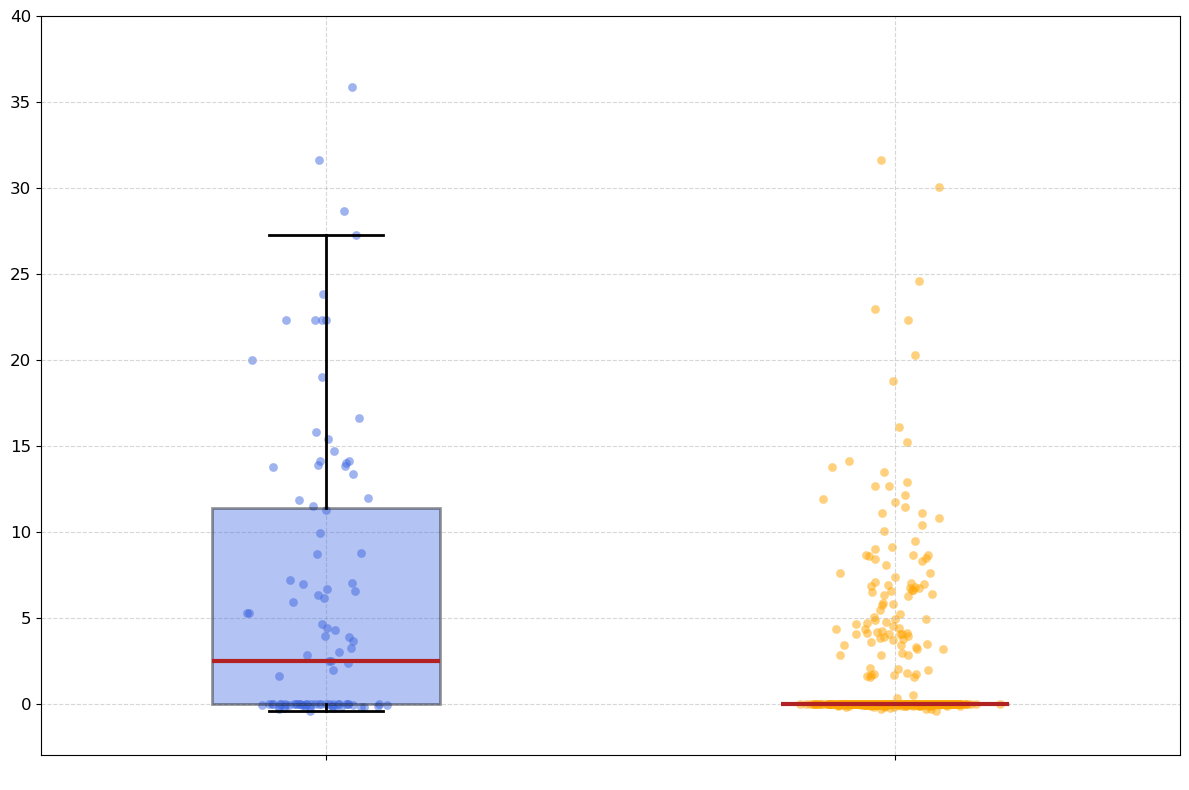

Number of WGD pairs: 99
Number of SSD pairs: 1245


In [176]:
data = [df_wgd_lca_zscores, df_ssd_lca_zscores]
positions = [0, 1]
colors = ['royalblue', 'orange']

plt.figure(figsize=(12, 8))

box = plt.boxplot(data, 
                  positions=positions, 
                  widths=0.4,
                  patch_artist=True, 
                  showfliers=False)

for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_edgecolor('black')
    patch.set_linewidth(2)
    patch.set_alpha(0.4)
    
for element in ['whiskers', 'caps']:
    for line in box[element]:
        line.set_linewidth(2)
        line.set_color('black')
        
for element in ['medians']:
    for line in box[element]:
        line.set_linewidth(3)
        line.set_color('firebrick')

for i, (scores, color) in enumerate(zip(data, colors)):
    jittered_x = np.random.normal(loc=positions[i], scale=0.05, size=len(scores))
    plt.scatter(jittered_x, scores, alpha=0.5, color=color, linewidth=0.2, label=['', ''][i])

plt.xticks(positions, [' ', ' '], fontsize=100)
plt.ylim(-3, 40)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tight_layout()
plt.savefig(f'../../local/pictures/ppi_bifan_zscores_boxplot_{s}.jpg', bbox_inches='tight')
plt.show()

print(f"Number of WGD pairs: {len(df_wgd_lca_parsed)}")
print(f"Number of SSD pairs: {len(df_ssd_lca_parsed)}")

In [177]:
ks_stat, ks_p_value = stats.ks_2samp(df_wgd_lca_zscores, df_ssd_lca_zscores)
print(f"KS test results with parameters:\nnetwork={network}\ntarget_homology={target_homology}\nremove_pre_2R={remove_SSD_pre_2R}")
print(75 * "=")
print(f"KS statistic: {ks_stat}, p-value: {ks_p_value}")

KS test results with parameters:
network=tarbase
target_homology=mix
remove_pre_2R=False
KS statistic: 0.45342582451016183, p-value: 1.0967497504488512e-17


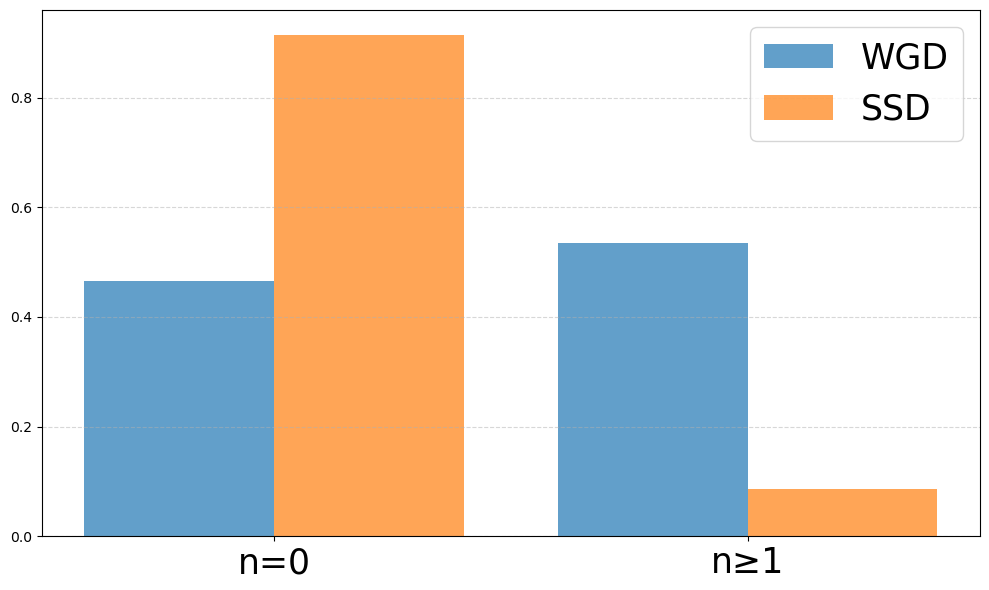

In [178]:
labels = ['n=0', 'n≥1']

def bin_bifans(count, labels=labels):
    if count == 0:
        return labels[0]
    else:
        return labels[1]

# Bin the counts
wgd_binned = pd.Series(df_wgd_lca_nbifan).apply(bin_bifans)
ssd_binned = pd.Series(df_ssd_lca_nbifan).apply(bin_bifans)

# Get relative frequencies for each bin
wgd_freq = wgd_binned.value_counts(normalize=True).reindex(labels, fill_value=0)
ssd_freq = ssd_binned.value_counts(normalize=True).reindex(labels, fill_value=0)

x = np.arange(len(labels))
width = 0.4

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, wgd_freq, width=width, label='WGD', alpha=0.7)
plt.bar(x + width/2, ssd_freq, width=width, label='SSD', alpha=0.7)

plt.xticks(x, labels, fontsize=25)
plt.xlabel('')
plt.title('')
plt.legend(fontsize=25)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig(f'../../local/pictures/ppi_bifan_nmotif_barplot_{s}.pdf', bbox_inches='tight')
plt.show()

________________________________________

## Subgenome analysis

In [179]:
subg_file = '../../1.1_retrieve_Hsa_ohnomirnas/gnathostomata_ohnolog_reference_singlecol.gene.tsv'
df_subg = pd.read_csv(subg_file, sep='\t', header=None)
cols = ['miRNA', 'subgenome', 'CLG']
df_subg.columns = cols
df_subg

def label_subgenome(df_dup, df_subg, prefix):
    # Create a dictionary from df_subg (miRNA -> subgenome)
    subg_dict = dict(zip(df_subg['miRNA'], df_subg['subgenome']))

    # Function to translate and label each miRNA
    def translate_miRNA(miRNA):
        miRNA_clean = miRNA.replace(prefix, "")
        return subg_dict.get(miRNA_clean, 'unknown')

    # Apply subgenome labels
    df_dup_cp = df_dup.copy()
    df_dup_cp['subg_1'] = df_dup_cp['miRNA_1'].apply(translate_miRNA)
    df_dup_cp['subg_2'] = df_dup_cp['miRNA_2'].apply(translate_miRNA)

    # Split into numeric and Greek part
    df_dup_cp['miRNA_1_1R'] = df_dup_cp['subg_1'].str.extract(r'(\d)')
    df_dup_cp['miRNA_1_2R'] = df_dup_cp['subg_1'].str.extract(r'(alpha|beta)')

    df_dup_cp['miRNA_2_1R'] = df_dup_cp['subg_2'].str.extract(r'(\d)')
    df_dup_cp['miRNA_2_2R'] = df_dup_cp['subg_2'].str.extract(r'(alpha|beta)')

    return df_dup_cp

df_wgd_lca_parsed_subg = label_subgenome(df_wgd_lca_parsed, df_subg, '')

n_1 =  31
n_2 =  33
n_3 =  26
n_4 =  9


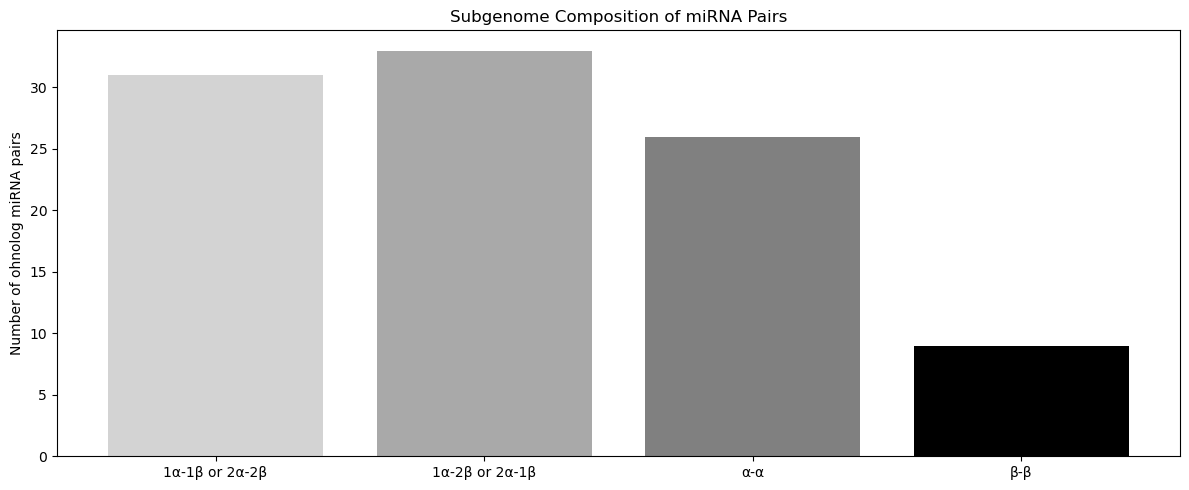

In [180]:
mask_1 = (
    ((df_wgd_lca_parsed_subg['miRNA_1_2R'] == 'alpha') & (df_wgd_lca_parsed_subg['miRNA_2_2R'] == 'beta') & (df_wgd_lca_parsed_subg['miRNA_1_1R'] == df_wgd_lca_parsed_subg['miRNA_2_1R'])) |
    ((df_wgd_lca_parsed_subg['miRNA_1_2R'] == 'beta') & (df_wgd_lca_parsed_subg['miRNA_2_2R'] == 'alpha') & (df_wgd_lca_parsed_subg['miRNA_1_1R'] == df_wgd_lca_parsed_subg['miRNA_2_1R']))
)

mask_2 = (
    ((df_wgd_lca_parsed_subg['miRNA_1_2R'] == 'alpha') & (df_wgd_lca_parsed_subg['miRNA_2_2R'] == 'beta') & (df_wgd_lca_parsed_subg['miRNA_1_1R'] != df_wgd_lca_parsed_subg['miRNA_2_1R'])) |
    ((df_wgd_lca_parsed_subg['miRNA_1_2R'] == 'beta') & (df_wgd_lca_parsed_subg['miRNA_2_2R'] == 'alpha') & (df_wgd_lca_parsed_subg['miRNA_1_1R'] != df_wgd_lca_parsed_subg['miRNA_2_1R']))
)

mask_3 = (
	(df_wgd_lca_parsed_subg['miRNA_1_2R'] == 'alpha') & (df_wgd_lca_parsed_subg['miRNA_2_2R'] == 'alpha') 
)

mask_4 = (
	(df_wgd_lca_parsed_subg['miRNA_1_2R'] == 'beta') & (df_wgd_lca_parsed_subg['miRNA_2_2R'] == 'beta') 
)

# add a column named "dup_subgenome_type" with "A" if mask_1 is True, "B" if mask_2 is True, and "C" if mask_3 is True
df_wgd_lca_parsed_subg['dup_subgenome_type'] = np.select(
	[mask_1, mask_2, mask_3, mask_4],
	['A', 'B', 'C', 'D']
)

n_1 = df_wgd_lca_parsed_subg[mask_1].shape[0]
n_2 = df_wgd_lca_parsed_subg[mask_2].shape[0]
n_3= df_wgd_lca_parsed_subg[mask_3].shape[0]
n_4 = df_wgd_lca_parsed_subg[mask_4].shape[0]

print("n_1 = ", n_1)
print("n_2 = ", n_2)
print("n_3 = ", n_3)
print("n_4 = ", n_4)

# Plot
plt.figure(figsize=(12, 5))
plt.bar(['1α-1β or 2α-2β', '1α-2β or 2α-1β', 'α-α', 'β-β'], [n_1, n_2, n_3, n_4], color=['lightgrey', 'darkgrey', 'grey', 'black'])
plt.ylabel('Number of ohnolog miRNA pairs')
plt.title('Subgenome Composition of miRNA Pairs')
plt.tight_layout()
plt.savefig(f'../../local/pictures/ppi_bifan_subgenome_numbers_{s}.jpg', bbox_inches='tight')
plt.show()

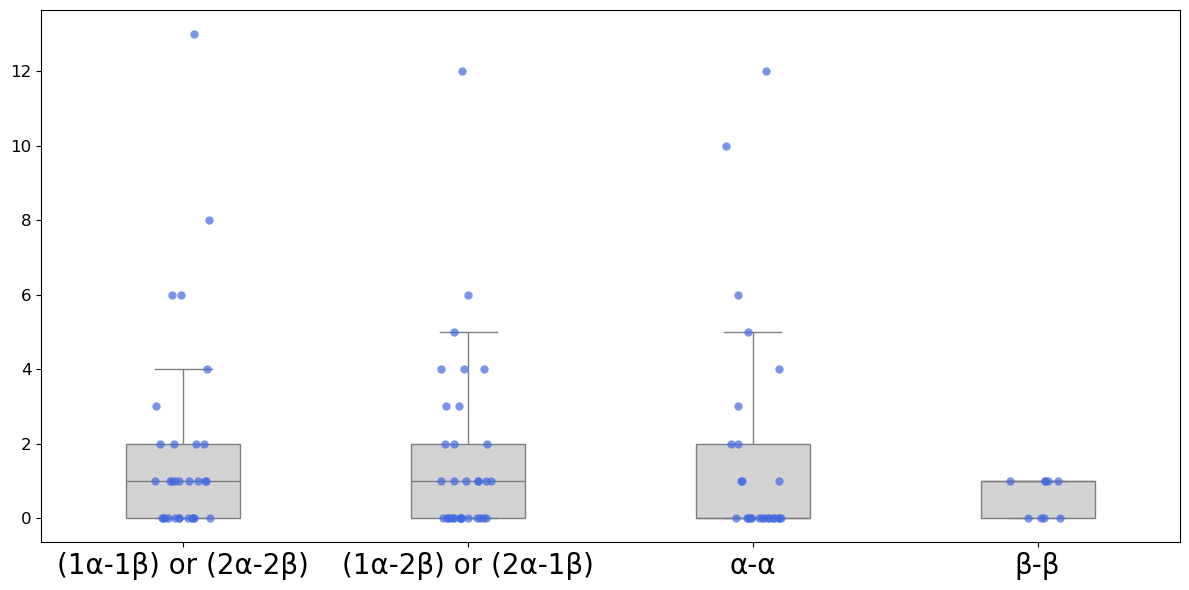

In [181]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='dup_subgenome_type', y='n_relevant_bifan', data=df_wgd_lca_parsed_subg, 
			order=['A', 'B', 'C', 'D'], showfliers=False, width=0.4, linewidth=1, color='lightgrey')
sns.stripplot(x='dup_subgenome_type', y='n_relevant_bifan', data=df_wgd_lca_parsed_subg, 
			order=['A', 'B', 'C', 'D'], color='royalblue', alpha=0.7, s=6, jitter=True)
plt.xlabel('', fontsize=14)
plt.ylabel('', fontsize=14)
v = ['(1α-1β) or (2α-2β)', '(1α-2β) or (2α-1β)', 'α-α', 'β-β']
plt.xticks(ticks=range(len(v)), labels=v, fontsize=12)
plt.title('', fontsize=16)
plt.xticks(fontsize=20)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig(f'../../local/pictures/ppi_bifan_subgenome_nbifan_{s}.jpg', bbox_inches='tight')
plt.show()

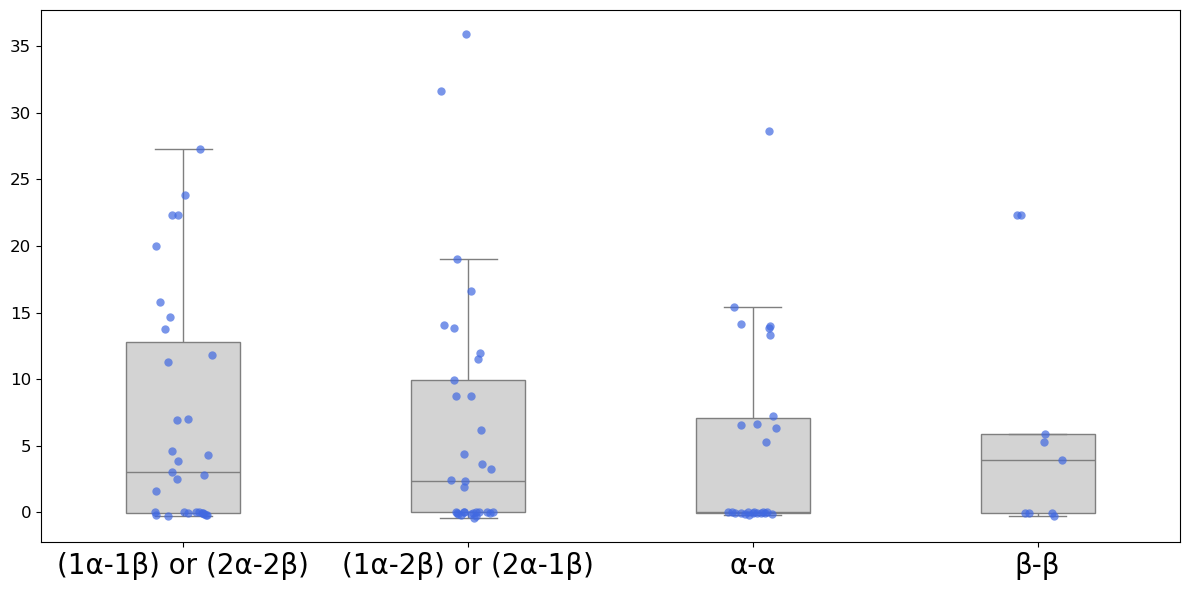

In [182]:
plt.figure(figsize=(12, 6))
df_wgd_lca_parsed_subg['Z-score'] = pd.to_numeric(df_wgd_lca_parsed_subg['Z-score'], errors='coerce')
sns.boxplot(x='dup_subgenome_type', y='Z-score', data=df_wgd_lca_parsed_subg, 
			order=['A', 'B', 'C', 'D'], showfliers=False, width=0.4, linewidth=1, color='lightgrey')
sns.stripplot(x='dup_subgenome_type', y='Z-score', data=df_wgd_lca_parsed_subg, 
			order=['A', 'B', 'C', 'D'], color='royalblue', alpha=0.7, s=6, jitter=True)
plt.xlabel('', fontsize=14)
plt.ylabel('', fontsize=14)
v = ['(1α-1β) or (2α-2β)', '(1α-2β) or (2α-1β)', 'α-α', 'β-β']
plt.xticks(ticks=range(len(v)), labels=v, fontsize=12)
plt.title('', fontsize=16)
plt.xticks(fontsize=20)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig(f'../../local/pictures/ppi_bifan_subgenome_zscore_{s}.jpg', bbox_inches='tight')
plt.show()

In [183]:
# compute KS pvalues for each pair of subgenome types
def compute_ks_pvalue(df1, subg_type1, subg_type2):
	"""
	Computes the KS p-value for the Z-scores of two subgenome types.
	"""
	df1_subg = df1[df1['dup_subgenome_type'] == subg_type1]
	df2_subg = df1[df1['dup_subgenome_type'] == subg_type2]
	
	if df1_subg.empty or df2_subg.empty:
		return None, None
	
	ks_stat, ks_p_value = stats.ks_2samp(df1_subg['Z-score'].astype(float), df2_subg['Z-score'].astype(float))
	
	return ks_stat, ks_p_value

subg_types = ['A', 'B', 'C', 'D']
ks_results = {}
for i in range(len(subg_types)):
	for j in range(i + 1, len(subg_types)):
		subg_type1 = subg_types[i]
		subg_type2 = subg_types[j]
		ks_stat, ks_p_value = compute_ks_pvalue(df_wgd_lca_parsed_subg, subg_type1, subg_type2)
		if ks_stat is not None and ks_p_value is not None:
			ks_results[(subg_type1, subg_type2)] = (ks_stat, ks_p_value)

print("KS test results for subgenome types:")
for (subg_type1, subg_type2), (ks_stat, ks_p_value) in ks_results.items():
	print(f"Subgenome types: {subg_type1} vs {subg_type2} - KS statistic: {ks_stat}, p-value: {ks_p_value}")

	

KS test results for subgenome types:
Subgenome types: A vs B - KS statistic: 0.12609970674486803, p-value: 0.9203793422373655
Subgenome types: A vs C - KS statistic: 0.18982630272952852, p-value: 0.603837040664749
Subgenome types: A vs D - KS statistic: 0.25089605734767023, p-value: 0.6703894632687203
Subgenome types: B vs C - KS statistic: 0.12237762237762238, p-value: 0.9539240518841648
Subgenome types: B vs D - KS statistic: 0.26262626262626265, p-value: 0.6279274651848843
Subgenome types: C vs D - KS statistic: 0.2905982905982906, p-value: 0.5107714680573413


____________________

## Expression on miRNATissueAtlas

In [341]:
dict_path = '../../1.1_retrieve_Hsa_ohnomirnas/ohnomirna_mgdb_to_gene.dic'

dic = {}
with open(dict_path) as f:
	for line in f:
		parts = line.strip().split('\t')
		if len(parts) == 2:
			dic[parts[1]] = parts[0]

In [342]:
avg_expr_matrix_path = '../../miRNATissueAtlas_expression/all_human_miRNA_rpmm_harmonized_meta_data.mgdb.csv'

with open(avg_expr_matrix_path) as f:
    lines = [line.strip().split('\t') for line in f.readlines()[:4]]
    
columns = list(zip(*lines))
merged_header = ['{},{}'.format(columns[i][0], ','.join(columns[i][1:])) for i in range(len(columns))]
h = '\t'.join(merged_header)

expr_df = pd.read_csv(avg_expr_matrix_path, index_col=None, sep='\t', header=None)
expr_df = expr_df.iloc[4:, :]
expr_df.columns = h.split('\t')
expr_df.set_index(expr_df.columns[0], inplace=True)
expr_df = expr_df[expr_df.index != 'unknown_mirna']
expr_df = expr_df[expr_df.index != 'premirna_not_in_mirgenedb']
expr_df = expr_df.apply(pd.to_numeric)
expr_df = expr_df.loc[:, expr_df.columns.str.endswith('mean')]

expr_df_norm = expr_df.div(expr_df.sum(axis=0), axis=1)
expr_df_norm

#expr_df_norm_filtered = expr_df_norm.loc[:, expr_df_norm.columns.str.startswith("tissue,", "cell_line,")]
#expr_df_norm_filtered = expr_df_norm.loc[:, expr_df_norm.columns.str.startswith("tissue,"]

expr_df_norm_filtered = expr_df_norm

/tmp/ipykernel_1448/2691840302.py:10: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262

In [472]:
def retrieve_expression(mirna, expr_df, dic):
    """
    Retrieves the expression values for a given miRNA from the expression DataFrame.
    If multiple entries exist (miRNA name duplicated), returns their average expression vector.
    """
    if mirna in dic:
        mirna = dic[mirna]

    if mirna in expr_df.index:
        expr_values = expr_df.loc[mirna]

        # Check if expr_values is a DataFrame (multiple rows with same miRNA name)
        if isinstance(expr_values, pd.DataFrame):
            # Average across duplicate rows
            expr_mean = expr_values.mean(axis=0).values
            return expr_mean.flatten()
        else:
            # Single row, return directly
            return expr_values.values.flatten()
    else:
        return None
    

def expression_correlation(expr_1, expr_2):
    """
    Computes log-transformed cosine similarity to account for expression magnitude.
    """
    if expr_1 is None or expr_2 is None:
        return np.nan
    # if one of the two expression vector is all 0 or NaN, return NaN
    if np.all(np.isnan(expr_1)) or np.all(np.isnan(expr_2)) or np.all(expr_1 == 0) or np.all(expr_2 == 0):
        return np.nan
    if len(expr_1) < 2 or len(expr_2) < 2:
        return np.nan
    if np.array_equal(expr_1, expr_2):
        return np.nan

    else:
        #m = cosine(expr_1, expr_2)
        #m = 1 - cosine(expr_1, expr_2)
        #m = stats.spearmanr(expr_1, expr_2).correlation
        m = stats.pearsonr(expr_1, expr_2).correlation
    print(f"Sum of expr_1: {np.sum(expr_1)}, Sum of expr_2: {np.sum(expr_2)}, m: {m}")
    return m

In [473]:
#df_wgd_lca_parsed_subg_bifanonly = df_wgd_lca_parsed_subg[df_wgd_lca_parsed_subg['Z-score'] >= 5]
df_wgd_lca_parsed_subg_bifanonly = df_wgd_lca_parsed_subg[df_wgd_lca_parsed_subg['n_relevant_bifan'] >= 1]

Processing pair (MIR101-1, MIR101-2) for subgenome type C
Sum of expr_1: 0.5549035127152905, Sum of expr_2: 0.5519665059134746, m: 0.9999704212736318
Processing pair (MIR103A2, MIR107) for subgenome type C
Sum of expr_1: 0.9691418716016549, Sum of expr_2: 0.3135257440116237, m: 0.6294837628750294
Processing pair (MIR125A, MIR125B2) for subgenome type C
Sum of expr_1: 0.8965007471480269, Sum of expr_2: 1.137942987543997, m: 0.41300247836216336
Processing pair (MIR129-1, MIR129-2) for subgenome type C
Sum of expr_1: 0.04734390223754879, Sum of expr_2: 0.05507316427432631, m: 0.990935930136434
Processing pair (MIR1-2, MIR206) for subgenome type C
Sum of expr_1: 0.9975752995752598, Sum of expr_2: 0.5660418728590779, m: 0.16975800258611978
Processing pair (MIR133A1, MIR133B) for subgenome type C
Sum of expr_1: 0.28938860323345933, Sum of expr_2: 0.0761978074714114, m: 0.846607787995691
Processing pair (MIR135A1, MIR135A2) for subgenome type C
Sum of expr_1: 0.033751576423745794, Sum of expr

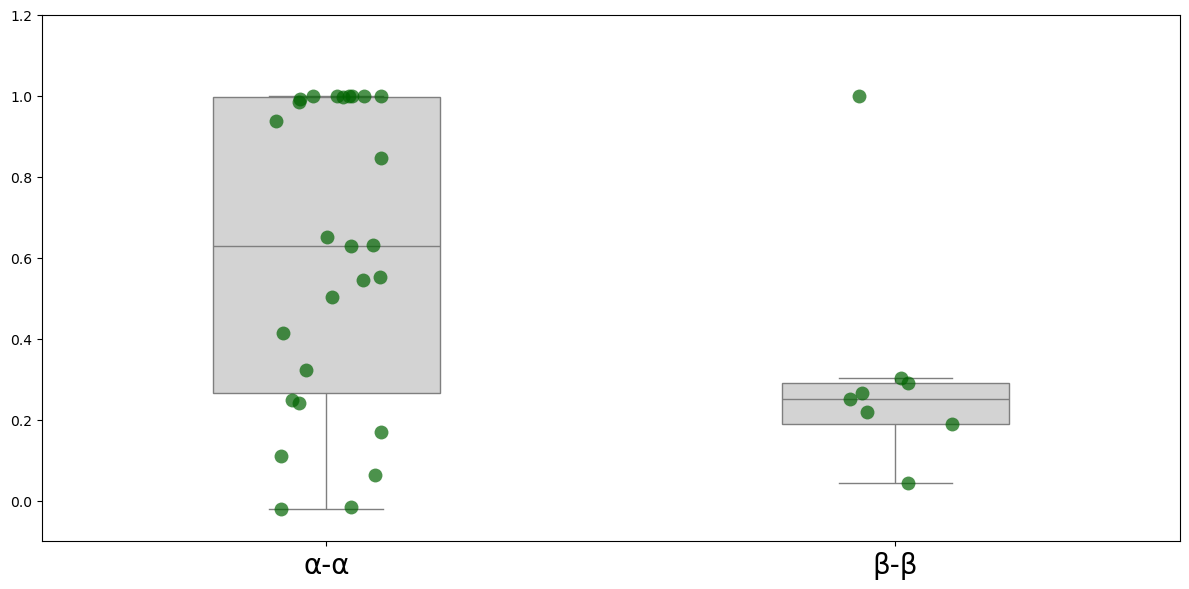


KS test results for expression correlations between subgenome pairs:
C vs D - KS statistic: 0.6197, p-value: 0.006597999701447976
Processing pair (MIR103A2, MIR107) for subgenome type C
Sum of expr_1: 0.9691418716016549, Sum of expr_2: 0.3135257440116237, m: 0.6294837628750294
Processing pair (MIR16-1, MIR16-2) for subgenome type C
Sum of expr_1: 2.207461015218989, Sum of expr_2: 2.2474058768018477, m: 0.9998789606504723
Processing pair (MIR181A1, MIR181A2) for subgenome type C
Sum of expr_1: 2.349268963703489, Sum of expr_2: 2.3586859624330985, m: 0.9997276761417795
Processing pair (MIR181B1, MIR181B2) for subgenome type C
Sum of expr_1: 0.4011171066571104, Sum of expr_2: 0.39957151544237424, m: 0.9999619270460972
Processing pair (MIR199A2, MIR199B) for subgenome type C
Sum of expr_1: 1.0840499688579035, Sum of expr_2: 0.9821900186871677, m: 0.9836171742365095
Processing pair (MIR26A1, MIR26B) for subgenome type C
Sum of expr_1: 4.336781290599543, Sum of expr_2: 0.9314629057618509, m

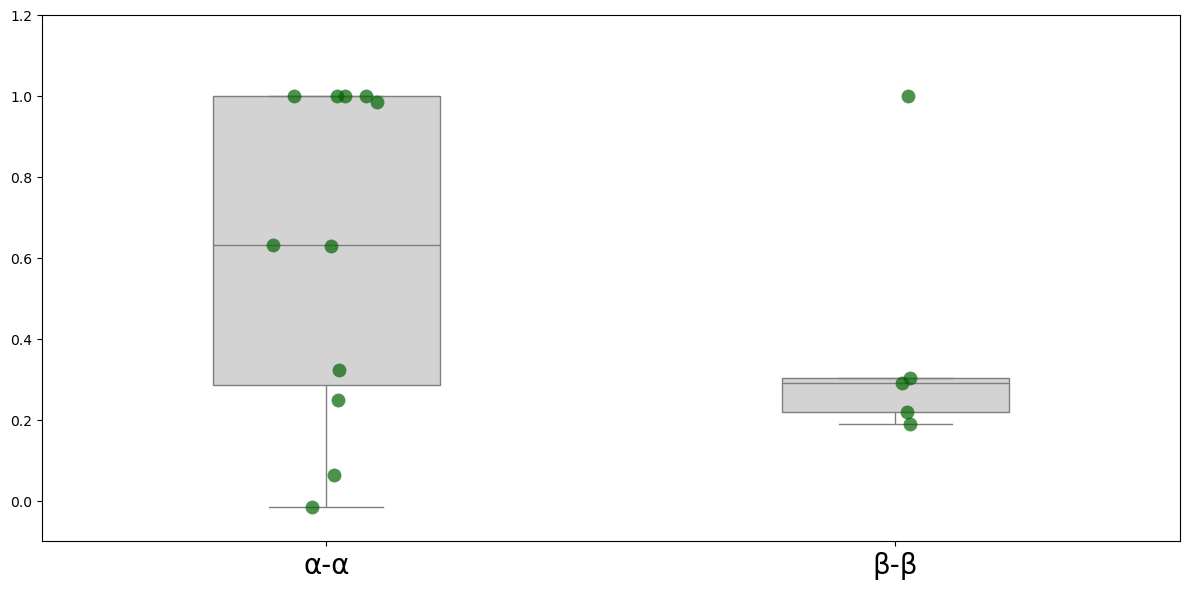


KS test results for expression correlations between subgenome pairs:
C vs D - KS statistic: 0.5273, p-value: 0.22664835164835168


In [474]:
def plot_expression_correlation(df, expr_df, dic):
    """
    Plots the expression correlation for each combination of subgenomes in the DataFrame.
    """
    #desired_order = ["A", "B", "C", "D"]
    desired_order = ["C", "D"]
    correlations = []

    for subg_type in desired_order:
        subg_df = df[df['dup_subgenome_type'] == subg_type]
        for _, row in subg_df.iterrows():
            print(f"Processing pair ({row['miRNA_1']}, {row['miRNA_2']}) for subgenome type {subg_type}")
            expr_1 = retrieve_expression(row['miRNA_1'], expr_df, dic)
            expr_2 = retrieve_expression(row['miRNA_2'], expr_df, dic)

            corr = expression_correlation(expr_1, expr_2)

            if np.isnan(corr):
                print(f"Skipping pair ({row['miRNA_1']}, {row['miRNA_2']}), missing expression data.")
                continue

            correlations.append((subg_type, corr))

    corr_df = pd.DataFrame(correlations, columns=['subgenome_pair', 'correlation'])

    if corr_df.empty:
        print("No valid correlations to plot. Check your miRNA mappings and expression DataFrame.")
        return

    plt.figure(figsize=(12, 6))
    sns.boxplot(
        x='subgenome_pair',
        y='correlation',
        data=corr_df,
        showfliers=False,
        color='lightgrey',
        width=0.4,
        linewidth=1,
        order=desired_order
    )
    sns.stripplot(
        x='subgenome_pair',
        y='correlation',
        data=corr_df,
        color='darkgreen',
        alpha=0.7,
        s=10,
        jitter=True,
        order=desired_order
    )
    plt.xlabel('')
    plt.ylabel('')
    plt.ylim(-0.1, 1.2)
    plt.title('')
    #v = ['(1α-1β) or (2α-2β)', '(1α-2β) or (2α-1β)', 'α-α', 'β-β']
    v = ['α-α', 'β-β']
    plt.xticks(ticks=range(len(v)), labels=v, fontsize=20)
    plt.tight_layout()
    plt.show()
    
	# Compute pairwise KS p-values for correlation distributions
    from scipy.stats import ks_2samp

    ks_results = {}
    for i in range(len(desired_order)):
        for j in range(i + 1, len(desired_order)):
            type1 = desired_order[i]
            type2 = desired_order[j]
            corrs_type1 = corr_df[corr_df['subgenome_pair'] == type1]['correlation']
            corrs_type2 = corr_df[corr_df['subgenome_pair'] == type2]['correlation']

            if corrs_type1.empty or corrs_type2.empty:
                continue

            ks_stat, ks_pvalue = ks_2samp(corrs_type1, corrs_type2)
            ks_results[(type1, type2)] = (ks_stat, ks_pvalue)

    print("\nKS test results for expression correlations between subgenome pairs:")
    for (type1, type2), (ks_stat, ks_pvalue) in ks_results.items():
        print(f"{type1} vs {type2} - KS statistic: {ks_stat:.4f}, p-value: {ks_pvalue}")
        
plot_expression_correlation(df_wgd_lca_parsed_subg, expr_df_norm_filtered, dic)
plot_expression_correlation(df_wgd_lca_parsed_subg_bifanonly, expr_df_norm_filtered, dic)

Sum of expr_1: 0.968151235904678, Sum of expr_2: 0.9691418716016549, m: 0.9999888702687418
Sum of expr_1: 0.968151235904678, Sum of expr_2: 0.3135257440116237, m: 0.6284127818603608


Sum of expr_1: 0.04214017191694541, Sum of expr_2: 0.44865539350866845, m: 0.43019527322421414
Sum of expr_1: 0.2467313774668638, Sum of expr_2: 0.44865539350866845, m: 0.3877660791619648
Sum of expr_1: 2.315456791223469, Sum of expr_2: 2.1829012435224033, m: 0.1532659631816686
Sum of expr_1: 0.8965007471480269, Sum of expr_2: 1.143014702199901, m: 0.40756516784036095
Sum of expr_1: 1.143014702199901, Sum of expr_2: 1.137942987543997, m: 0.9993689978822083
Sum of expr_1: 0.49913667042972615, Sum of expr_2: 0.5660418728590779, m: 0.16981551243328633
Sum of expr_1: 0.28938860323345933, Sum of expr_2: 0.0761978074714114, m: 0.846607787995691
Sum of expr_1: 0.033751576423745794, Sum of expr_2: 0.033342356381690405, m: 0.1674486246182556
Sum of expr_1: 0.034887714043569905, Sum of expr_2: 0.033342356381690405, m: 0.14484812574542613
Sum of expr_1: 0.6502752314852109, Sum of expr_2: 0.8184460375055418, m: 0.18038480902167073
Sum of expr_1: 3.646524711866527, Sum of expr_2: 0.2644405748746017

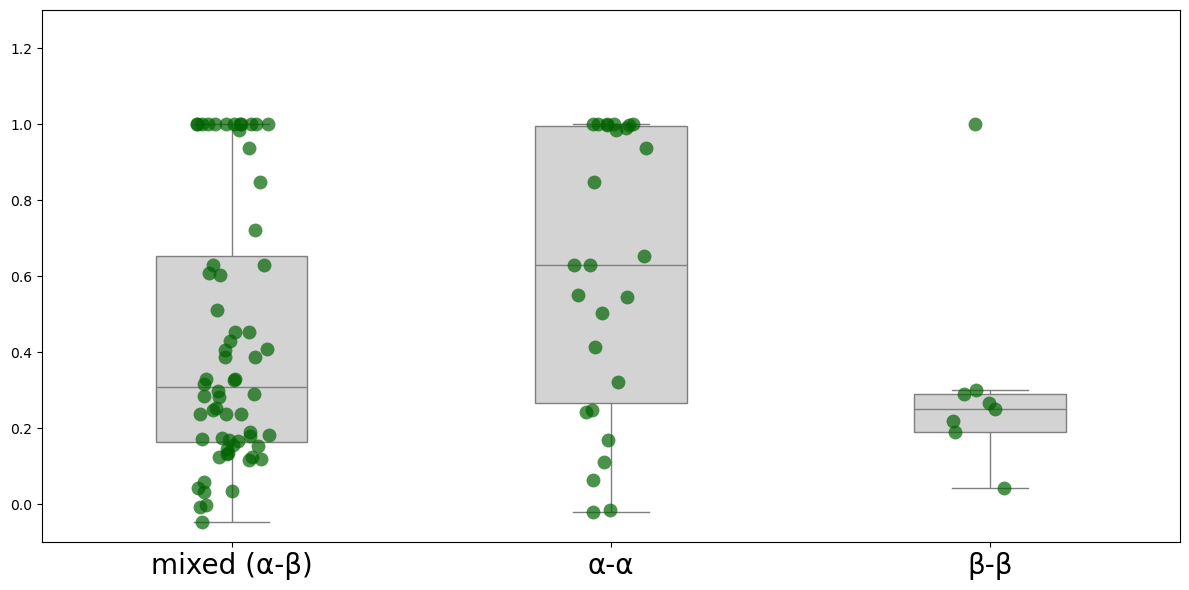


KS test results for expression correlations between subgenome pairs:
mixed vs C - KS statistic: 0.3257, p-value: 0.029761261185035665
mixed vs D - KS statistic: 0.3889, p-value: 0.13586844897698588
C vs D - KS statistic: 0.6197, p-value: 0.006597999701447976
Sum of expr_1: 0.968151235904678, Sum of expr_2: 0.9691418716016549, m: 0.9999888702687418
Sum of expr_1: 0.968151235904678, Sum of expr_2: 0.3135257440116237, m: 0.6284127818603608
Sum of expr_1: 0.04214017191694541, Sum of expr_2: 0.44865539350866845, m: 0.43019527322421414
Sum of expr_1: 0.2467313774668638, Sum of expr_2: 0.44865539350866845, m: 0.3877660791619648
Sum of expr_1: 3.646524711866527, Sum of expr_2: 0.26444057487460176, m: 0.28921898267840573
Sum of expr_1: 3.646524711866527, Sum of expr_2: 0.11015955492239632, m: 0.29881382266114614
Sum of expr_1: 0.1253148596213286, Sum of expr_2: 0.03371220962368734, m: 0.40616397538225957
Sum of expr_1: 2.2474058768018477, Sum of expr_2: 0.0948485801915995, m: 0.132327198427695

/tmp/ipykernel_1448/4027000323.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['group'] = df['dup_subgenome_type'].apply(lambda x: 'mixed' if x in ['A', 'B'] else x)


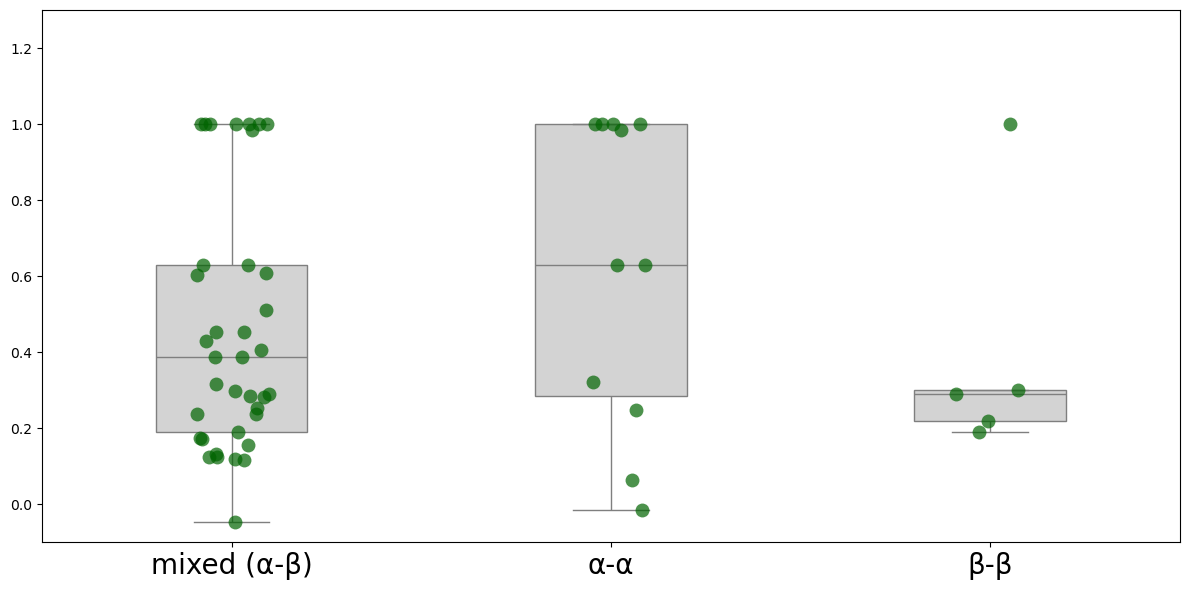


KS test results for expression correlations between subgenome pairs:
mixed vs C - KS statistic: 0.3931, p-value: 0.11035191011323187
mixed vs D - KS statistic: 0.3405, p-value: 0.5862075451292397
C vs D - KS statistic: 0.5273, p-value: 0.22664835164835168


In [475]:
def plot_expression_correlation(df, expr_df, dic):
    """
    Plots the expression correlation comparing 'mixed' (A and B combined), 'C', and 'D' subgenome types.
    """
    df['group'] = df['dup_subgenome_type'].apply(lambda x: 'mixed' if x in ['A', 'B'] else x)
    desired_order = ['mixed', 'C', 'D']
    label_map = {'mixed': 'mixed (α-β)', 'C': 'α-α', 'D': 'β-β'}
    correlations = []

    for group in desired_order:
        group_df = df[df['group'] == group]
        for _, row in group_df.iterrows():
            expr_1 = retrieve_expression(row['miRNA_1'], expr_df, dic)
            expr_2 = retrieve_expression(row['miRNA_2'], expr_df, dic)

            corr = expression_correlation(expr_1, expr_2)

            if np.isnan(corr):
                print(f"Skipping pair ({row['miRNA_1']}, {row['miRNA_2']}), missing expression data.")
                continue

            correlations.append((group, corr))

    corr_df = pd.DataFrame(correlations, columns=['subgenome_pair', 'correlation'])

    if corr_df.empty:
        print("No valid correlations to plot. Check your miRNA mappings and expression DataFrame.")
        return

    plt.figure(figsize=(12, 6))
    sns.boxplot(
        x='subgenome_pair',
        y='correlation',
        data=corr_df,
        showfliers=False,
        color='lightgrey',
        width=0.4,
        linewidth=1,
        order=desired_order
    )
    sns.stripplot(
        x='subgenome_pair',
        y='correlation',
        data=corr_df,
        color='darkgreen',
        alpha=0.7,
        s=10,
        jitter=True,
        order=desired_order
    )
    plt.xlabel('')
    plt.ylabel('')
    plt.ylim(-0.1, 1.3)
    plt.title('')
    xtick_labels = [label_map[g] for g in desired_order]
    plt.xticks(ticks=range(len(xtick_labels)), labels=xtick_labels, fontsize=20)
    plt.tight_layout()
    plt.show()

    # Compute pairwise KS p-values for correlation distributions
    from scipy.stats import ks_2samp

    ks_results = {}
    for i in range(len(desired_order)):
        for j in range(i + 1, len(desired_order)):
            type1 = desired_order[i]
            type2 = desired_order[j]
            corrs_type1 = corr_df[corr_df['subgenome_pair'] == type1]['correlation']
            corrs_type2 = corr_df[corr_df['subgenome_pair'] == type2]['correlation']

            if corrs_type1.empty or corrs_type2.empty:
                continue

            ks_stat, ks_pvalue = ks_2samp(corrs_type1, corrs_type2)
            ks_results[(type1, type2)] = (ks_stat, ks_pvalue)

    print("\nKS test results for expression correlations between subgenome pairs:")
    for (type1, type2), (ks_stat, ks_pvalue) in ks_results.items():
        print(f"{type1} vs {type2} - KS statistic: {ks_stat:.4f}, p-value: {ks_pvalue}")

plot_expression_correlation(df_wgd_lca_parsed_subg, expr_df_norm_filtered, dic)
plot_expression_correlation(df_wgd_lca_parsed_subg_bifanonly, expr_df_norm_filtered, dic)

Sum of expr_1: 0.968151235904678, Sum of expr_2: 0.9691418716016549, m: 0.9999888702687418
Sum of expr_1: 0.968151235904678, Sum of expr_2: 0.3135257440116237, m: 0.6284127818603608
Sum of expr_1: 0.04214017191694541, Sum of expr_2: 0.2467313774668638, m: 0.301761493306178
Sum of expr_1: 0.04214017191694541, Sum of expr_2: 0.44865539350866845, m: 0.43019527322421414
Sum of expr_1: 0.2467313774668638, Sum of expr_2: 0.44865539350866845, m: 0.3877660791619648
Sum of expr_1: 2.315456791223469, Sum of expr_2: 2.1829012435224033, m: 0.1532659631816686
Sum of expr_1: 0.8965007471480269, Sum of expr_2: 1.143014702199901, m: 0.40756516784036095
Sum of expr_1: 1.143014702199901, Sum of expr_2: 1.137942987543997, m: 0.9993689978822083
Sum of expr_1: 0.49913667042972615, Sum of expr_2: 0.5660418728590779, m: 0.16981551243328633
Sum of expr_1: 0.28938860323345933, Sum of expr_2: 0.0761978074714114, m: 0.846607787995691
Sum of expr_1: 0.033751576423745794, Sum of expr_2: 0.033342356381690405, m: 0.

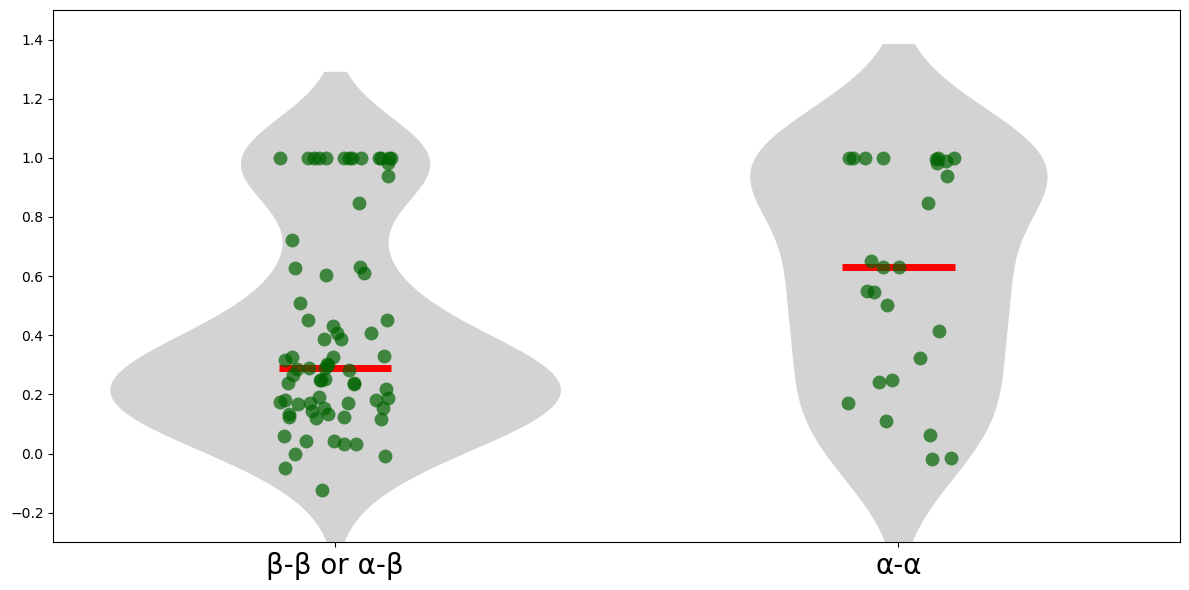


KS test results for expression correlations between subgenome pairs:
mixed vs C - KS statistic: 0.3525, p-value: 0.012364154921673445
Sum of expr_1: 0.968151235904678, Sum of expr_2: 0.9691418716016549, m: 0.9999888702687418
Sum of expr_1: 0.968151235904678, Sum of expr_2: 0.3135257440116237, m: 0.6284127818603608
Sum of expr_1: 0.04214017191694541, Sum of expr_2: 0.2467313774668638, m: 0.301761493306178
Sum of expr_1: 0.04214017191694541, Sum of expr_2: 0.44865539350866845, m: 0.43019527322421414
Sum of expr_1: 0.2467313774668638, Sum of expr_2: 0.44865539350866845, m: 0.3877660791619648
Sum of expr_1: 3.646524711866527, Sum of expr_2: 0.26444057487460176, m: 0.28921898267840573
Sum of expr_1: 3.646524711866527, Sum of expr_2: 0.11015955492239632, m: 0.29881382266114614
Sum of expr_1: 0.26444057487460176, Sum of expr_2: 0.11015955492239632, m: 0.18880979358314748
Sum of expr_1: 0.1253148596213286, Sum of expr_2: 0.03371220962368734, m: 0.40616397538225957
Sum of expr_1: 2.24740587680

/tmp/ipykernel_1448/3071959401.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['group'] = df['dup_subgenome_type'].apply(lambda x: 'mixed' if x in ['A', 'B', 'D'] else x)


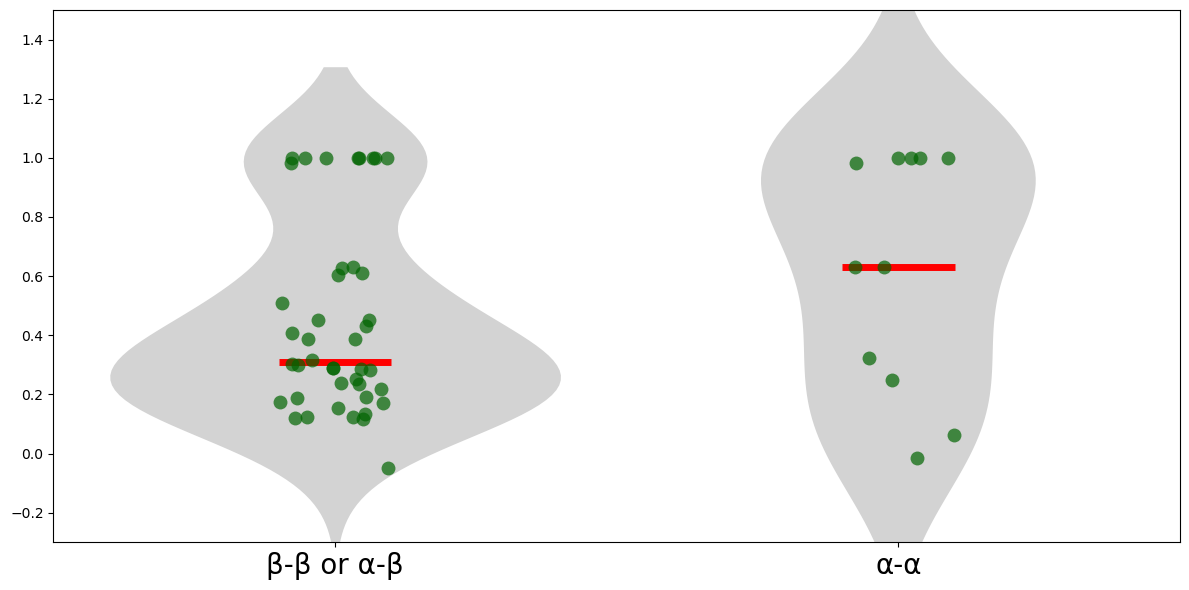


KS test results for expression correlations between subgenome pairs:
mixed vs C - KS statistic: 0.3983, p-value: 0.09271318989550684


In [476]:
def plot_expression_correlation(df, expr_df, dic):
    """
    Plots the expression correlation comparing 'mixed' (A and B combined), 'C', and 'D' subgenome types.
    """
    df['group'] = df['dup_subgenome_type'].apply(lambda x: 'mixed' if x in ['A', 'B', 'D'] else x)
    desired_order = ['mixed', 'C']
    label_map = {'mixed': 'β-β or α-β', 'C': 'α-α'}
    correlations = []

    for group in desired_order:
        group_df = df[df['group'] == group]
        for _, row in group_df.iterrows():
            expr_1 = retrieve_expression(row['miRNA_1'], expr_df, dic)
            expr_2 = retrieve_expression(row['miRNA_2'], expr_df, dic)

            corr = expression_correlation(expr_1, expr_2)

            if np.isnan(corr):
                print(f"Skipping pair ({row['miRNA_1']}, {row['miRNA_2']}), missing expression data.")
                continue

            correlations.append((group, corr))

    corr_df = pd.DataFrame(correlations, columns=['subgenome_pair', 'correlation'])

    if corr_df.empty:
        print("No valid correlations to plot. Check your miRNA mappings and expression DataFrame.")
        return

    plt.figure(figsize=(12, 6))
    sns.boxplot(
        x='subgenome_pair',
        y='correlation',
        data=corr_df,
        showfliers=False,
        color='lightgrey',
        width=0.2,
        linewidth=1,
        order=desired_order,
        boxprops=dict(visible=False),
        whiskerprops=dict(visible=False),
        capprops=dict(visible=False),
        medianprops=dict(color='red', linewidth=5)
    )
    sns.stripplot(
        x='subgenome_pair',
        y='correlation',
        data=corr_df,
        color='darkgreen',
        alpha=0.7,
        s=10,
        jitter=True,
        order=desired_order
    )
    sns.violinplot(
        x='subgenome_pair',
        y='correlation',
        data=corr_df,
        order=desired_order,
        inner=None,
        color='lightgrey',
        linewidth=0,
    )
    plt.xlabel('')
    plt.ylabel('')
    plt.ylim(-0.3, 1.5)
    plt.title('')
    xtick_labels = [label_map[g] for g in desired_order]
    plt.xticks(ticks=range(len(xtick_labels)), labels=xtick_labels, fontsize=20)
    plt.tight_layout()
    plt.show()

    # Compute pairwise KS p-values for correlation distributions
    from scipy.stats import ks_2samp

    ks_results = {}
    for i in range(len(desired_order)):
        for j in range(i + 1, len(desired_order)):
            type1 = desired_order[i]
            type2 = desired_order[j]
            corrs_type1 = corr_df[corr_df['subgenome_pair'] == type1]['correlation']
            corrs_type2 = corr_df[corr_df['subgenome_pair'] == type2]['correlation']

            if corrs_type1.empty or corrs_type2.empty:
                continue

            ks_stat, ks_pvalue = ks_2samp(corrs_type1, corrs_type2)
            ks_results[(type1, type2)] = (ks_stat, ks_pvalue)

    print("\nKS test results for expression correlations between subgenome pairs:")
    for (type1, type2), (ks_stat, ks_pvalue) in ks_results.items():
        print(f"{type1} vs {type2} - KS statistic: {ks_stat:.4f}, p-value: {ks_pvalue}")

plot_expression_correlation(df_wgd_lca_parsed_subg, expr_df_norm_filtered, dic)
plot_expression_correlation(df_wgd_lca_parsed_subg_bifanonly, expr_df_norm_filtered, dic)

In [477]:
def compute_expression_correlation(df, expr_df, dic, label):
    #df['group'] = df['dup_subgenome_type'].apply(lambda x: 'mixed' if x in ['A', 'B', 'D'] else x)
    df['group'] = df['dup_subgenome_type'].apply(lambda x: ('D' if x in ['D'] else ('C' if x in ['C'] else 'mixed')))
    desired_order = ['mixed', 'C']
    correlations = []

    for group in desired_order:
        group_df = df[df['group'] == group]
        for _, row in group_df.iterrows():
            expr_1 = retrieve_expression(row['miRNA_1'], expr_df, dic)
            expr_2 = retrieve_expression(row['miRNA_2'], expr_df, dic)
            corr = expression_correlation(expr_1, expr_2)
            if np.isnan(corr):
                continue
            correlations.append((group, corr, label))

    return pd.DataFrame(correlations, columns=['subgenome_pair', 'correlation', 'filtering'])

Sum of expr_1: 0.968151235904678, Sum of expr_2: 0.9691418716016549, m: 0.9999888702687418
Sum of expr_1: 0.968151235904678, Sum of expr_2: 0.3135257440116237, m: 0.6284127818603608
Sum of expr_1: 0.04214017191694541, Sum of expr_2: 0.44865539350866845, m: 0.43019527322421414
Sum of expr_1: 0.2467313774668638, Sum of expr_2: 0.44865539350866845, m: 0.3877660791619648
Sum of expr_1: 2.315456791223469, Sum of expr_2: 2.1829012435224033, m: 0.1532659631816686
Sum of expr_1: 0.8965007471480269, Sum of expr_2: 1.143014702199901, m: 0.40756516784036095
Sum of expr_1: 1.143014702199901, Sum of expr_2: 1.137942987543997, m: 0.9993689978822083
Sum of expr_1: 0.49913667042972615, Sum of expr_2: 0.5660418728590779, m: 0.16981551243328633
Sum of expr_1: 0.28938860323345933, Sum of expr_2: 0.0761978074714114, m: 0.846607787995691
Sum of expr_1: 0.033751576423745794, Sum of expr_2: 0.033342356381690405, m: 0.1674486246182556
Sum of expr_1: 0.034887714043569905, Sum of expr_2: 0.033342356381690405, m

/tmp/ipykernel_1448/525767556.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['group'] = df['dup_subgenome_type'].apply(lambda x: ('D' if x in ['D'] else ('C' if x in ['C'] else 'mixed')))


Sum of expr_1: 2.207461015218989, Sum of expr_2: 2.2474058768018477, m: 0.9998789606504723
Sum of expr_1: 2.349268963703489, Sum of expr_2: 2.3586859624330985, m: 0.9997276761417795
Sum of expr_1: 0.4011171066571104, Sum of expr_2: 0.39957151544237424, m: 0.9999619270460972
Sum of expr_1: 1.0840499688579035, Sum of expr_2: 0.9821900186871677, m: 0.9836171742365095
Sum of expr_1: 4.336781290599543, Sum of expr_2: 0.9314629057618509, m: 0.6301400656790339
Sum of expr_1: 1.8637139797591686, Sum of expr_2: 1.506208328814025, m: 0.32192107178845
Sum of expr_1: 0.1853108577311059, Sum of expr_2: 0.48707213554813183, m: 0.2488404341190245
Sum of expr_1: 0.8230656005700834, Sum of expr_2: 0.815392226816314, m: 0.9999586160096601
Sum of expr_1: 2.292436080391767, Sum of expr_2: 3.6092954175347067, m: 0.06305017072598265
Sum of expr_1: 0.3527314096921186, Sum of expr_2: 2.3961575402261857, m: -0.014692047784547572


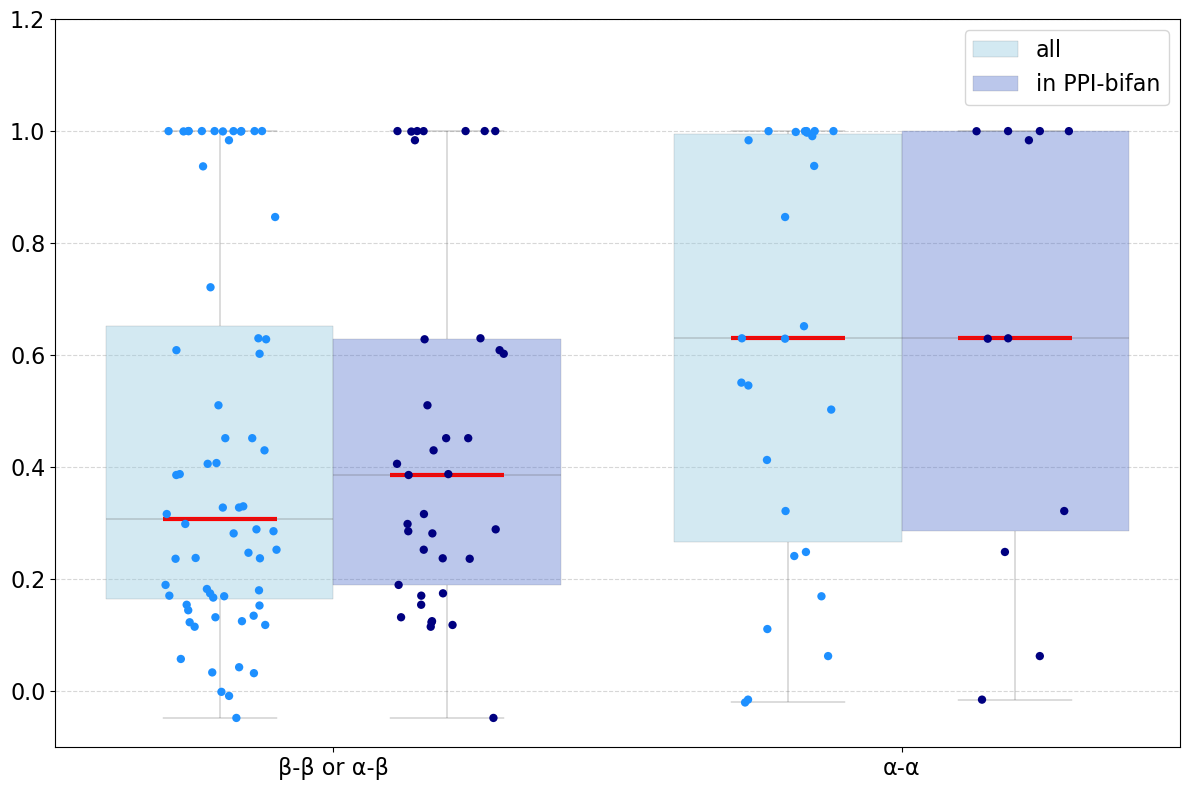

In [490]:
df_all = compute_expression_correlation(df_wgd_lca_parsed_subg, expr_df_norm_filtered, dic, label='all')
df_bifan = compute_expression_correlation(df_wgd_lca_parsed_subg_bifanonly, expr_df_norm_filtered, dic, label='in PPI-bifan')
corr_df = pd.concat([df_all, df_bifan], ignore_index=True)

desired_order = ['mixed', 'C']
#desired_order = ['C', 'D']  # Adjusted for the new label mapping
label_map = {'mixed': 'β-β or α-β', 'C': 'α-α'}
#label_map = {'D': 'β-β', 'C': 'α-α'}
xtick_labels = [label_map[g] for g in desired_order]
fig, ax = plt.subplots(figsize=(12, 8))

sns.boxplot(
	x='subgenome_pair',
	y='correlation',
	hue='filtering',
	data=corr_df,
	order=desired_order,
	palette={'all': 'skyblue', 'in PPI-bifan': 'royalblue'},
	ax=ax,
	linewidth=0.3,
    boxprops=dict(alpha=0.4)
)

sns.stripplot(
    x='subgenome_pair',
    y='correlation',
    hue='filtering',
    data=corr_df,
    order=desired_order,
    dodge=True,
    #alpha=0.8,
    size=6,
    jitter=0.2,
    palette={'all': 'dodgerblue', 'in PPI-bifan': 'navy'},
    ax=ax
)


handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2], labels[:2], fontsize=16, loc='upper right')

medians = corr_df.groupby(['subgenome_pair', 'filtering'])['correlation'].median().reset_index()
xticks = ax.get_xticks()
offset = 0.2

for i, subgenome in enumerate(desired_order):
    for j, filtering in enumerate(['all', 'in PPI-bifan']):
        median = medians[
            (medians['subgenome_pair'] == subgenome) & 
            (medians['filtering'] == filtering)
        ]['correlation'].values[0]
        x = xticks[i] - offset if filtering == 'all' else xticks[i] + offset
        ax.hlines(median, x - 0.1, x + 0.1, color='red', linewidth=3)

plt.xticks(ticks=xticks, labels=[label_map[g] for g in desired_order], fontsize=16)
plt.yticks(np.arange(0., 1.4, 0.2), fontsize=16)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.xlabel('')
plt.ylabel('')
#plt.ylim(-0.05, 1.1)
plt.tight_layout()
plt.show()

In [479]:
for i, subgenome in enumerate(desired_order):
    dist_all = corr_df[(corr_df['subgenome_pair'] == subgenome) & (corr_df['filtering'] == 'all')]['correlation']
    dist_bifan = corr_df[(corr_df['subgenome_pair'] == subgenome) & (corr_df['filtering'] == 'in bifan')]['correlation']
    
    if dist_all.empty or dist_bifan.empty:
        continue
    
    ks_stat, ks_pval = ks_2samp(dist_all, dist_bifan)
    print(f"{subgenome} → KS stat: {ks_stat:.3f}, p = {ks_pval}")

In [480]:
for i, subgenome in enumerate(desired_order):
    dist_all = corr_df[(corr_df['subgenome_pair'] == subgenome) & (corr_df['filtering'] == 'all')]['correlation']
    dist_bifan = corr_df[(corr_df['subgenome_pair'] == subgenome) & (corr_df['filtering'] == 'in bifan')]['correlation']
    
    if dist_all.empty or dist_bifan.empty:
        continue
    
    mann_whitney_stat, mann_whitney_pval = stats.mannwhitneyu(dist_all, dist_bifan, alternative='two-sided')
    print(f"{subgenome} → Mann-Whitney U stat: {mann_whitney_stat:.3f}, p = {mann_whitney_pval}")

In [481]:
corr_df['correlation'].unique()

array([ 9.99988870e-01,  6.28412782e-01,  4.30195273e-01,  3.87766079e-01,
        1.53265963e-01,  4.07565168e-01,  9.99368998e-01,  1.69815512e-01,
        8.46607788e-01,  1.67448625e-01,  1.44848126e-01,  1.80384809e-01,
        2.89218983e-01,  2.98813823e-01,  2.38130460e-01,  4.06163975e-01,
        3.30285607e-01,  5.78898186e-02,  1.35077799e-01,  3.25390942e-02,
        1.32327198e-01,  3.38852802e-02,  2.36712912e-01,  2.37549926e-01,
        3.28172500e-01,  3.28088289e-01,  9.99952962e-01,  1.23398859e-01,
        1.25313765e-01,  9.83617174e-01,  9.99981448e-01,  3.16553341e-01,
        2.85872181e-01,  7.21241414e-01,  9.99967970e-01,  9.37020119e-01,
        6.08954305e-01,  9.99881662e-01,  9.99999820e-01,  6.30192617e-01,
        1.18585360e-01,  1.54620436e-01,  9.99961957e-01,  1.15427979e-01,
        1.75027490e-01,  2.52855304e-01,  9.99125150e-01,  6.02554970e-01,
       -8.05753119e-03,  4.31405585e-02,  9.99912040e-01,  9.99983338e-01,
        9.99387259e-01,  